# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



# Imports

In [1]:
# !pip install anndata lightgbm

In [2]:
# !conda install -c conda-forge graph-tool -y 

In [3]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import tqdm
import scipy
import json

os.environ['KMP_DUPLICATE_LIB_OK']='True'

work_dir = '../output'
resource_dir = '../resources'
os.makedirs(f'{work_dir}', exist_ok=True)

In [4]:
methods = ['Random',
 'CollectRI',
 'FigR',
 'CellOracle',
 'GRaNIE',
 'ANANSE',
 'scGLUE',
 'Scenic+',
 'HKG',
 'Positive',
 'Negative',
 'Positive Control',
 'Negative Control']

surragate_names = {'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
                   'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
                   'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
                   'figr':'FigR', 'figr_sign':'FigR-signs',
                   'baseline':'Baseline',
                   'cov_net': 'Pearson cov',
                   'granie':'GRaNIE',
                   'ananse':'ANANSE',
                   'scglue':'scGLUE',
                   
                   'positive_control':'Positive Control',
                   'negative_control':'Negative Control',
                   'pearson':'Pearson',
                   'SL':'SLA'
                   }

# COLORS = {
#     'Random': '#74ab8c',
#     'CollectRI': '#83b17b',
#     'FigR': '#96b577',
#     'CellOracle': '#b0b595',
#     'GRaNIE': '#c9b4b1',
#     'ANANSE': '#e2b1cd',
#     'scGLUE': '#e5b8dc',
#     'Scenic+': '#dfc2e5',
#     'HKG': '#e7d2ec',
#     'Positive': 'darkblue',
#     'Negative': 'indianred',
#     'Positive Control': 'darkblue',
#     'Negative Control': 'indianred'
# }

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#56B4E9',
    'CellOracle': '#b0b595',
    'GRaNIE': '#009E73',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#D55E00',
    'Scenic+': '#dfc2e5',
    'HKGs': 'darkblue',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}
LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRaNIE': ':',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': '-',
}

In [5]:
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
control_compound = 'Dimethyl Sulfoxide'


def shuffle_grn(grn):
    grn_s = grn.copy()
    grn_s['source'] = grn_s['source'].sample(frac=1).reset_index(drop=True)
    grn_s['target'] = grn_s['target'].sample(frac=1).reset_index(drop=True)
    dup_flags = grn_s[['source','target']].duplicated()
    grn_s = grn_s[~dup_flags].reset_index(drop=True)
    if grn_s.duplicated().sum()>0:
        raise ValueError('')
    return grn_s
def sign_grn(grn):
    grn_sign = grn.copy()
    weights = grn_sign.weight
    weights = [1 if weight>0 else -1 for weight in weights]
    grn_sign.weight = weights
    return grn_sign


# housekeeping genes
if False:
    df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)

    housekeeping_genes = df.loc[:, 0]  # Gene names
    housekeeping_genes = df_train.columns[df_train.columns.isin(housekeeping_genes)].values
    np.savetxt(f'{work_dir}/benchmark/housekeeping_genes.txt', housekeeping_genes, fmt='%s')
else:
    housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)

print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

if False:
    collectRI = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
    collectRI.to_csv(f'{work_dir}/collectri.csv')


Number of housekeeping genes: 3804


In [6]:
grn_model_names = ['collectRI', 'figr', 'celloracle', 'granie', 'scglue', 'scenicplus']

n_nets = len(grn_model_names)

grn_models_dict = {}
for name in grn_model_names:
    grn_models_dict[name] = pd.read_csv(f'../output/benchmark/grn_models/{name}.csv', index_col=0)

grn_models_dict = {surragate_names[name]:grn for name, grn in grn_models_dict.items()}

In [29]:
reg_type = 'ridge'
theta = 0.5

mat = []
#for i_plot, norm_method in enumerate(['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm']):
for i_plot, norm_method in enumerate(['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm']):
    row = []
    for grn_model in ['negative_control', 'positive_control', 'collectRI', 'GRANIE', 'ANANSE', 'FigR', 'CellOracle', 'scGLUE', 'scenicplus']:
        file = f'{work_dir}/benchmark/scores/{reg_type}/{theta}/{norm_method}/{grn_model}_None.json'
        if not os.path.exists(file):
            print(f'Missing file: {file}')
            mean_score = np.nan
        else:
            with open(file, 'r') as f:
                data = json.load(f)
            mean_score = np.mean(data['mean_score_r2'])
        row.append(mean_score)
    mat.append(row)
mat = np.asarray(mat)

print(mat)

[[-3.61101318e-02  2.50024781e-01 -6.03950086e-02 -8.92271171e-02
  -2.72711168e-03 -1.90486044e-02 -1.11704434e+01 -1.32906799e-02
  -8.68137819e+01]
 [-3.39494486e-02 -1.08911019e-01 -6.22137324e-02 -7.37003448e+01
  -3.18154986e-03 -2.24890162e-02 -7.62217811e-02 -2.43935507e-02
  -1.15943697e+03]
 [-3.48527666e-02  2.57492281e-01 -6.54979384e-02 -7.16603957e+01
  -3.78648505e-03 -2.56206052e-02 -9.25977144e+00 -7.21686506e-03
  -1.42254871e+02]
 [-3.47215702e-02  2.34201933e-02 -6.46406996e-02 -1.75753686e+02
  -3.27472158e-03 -2.35048657e-02 -1.27101939e-01 -2.46665744e-02
  -8.17682910e+02]
 [-3.48130693e-02  2.95736683e-01 -6.20642864e-02 -2.67524692e+00
  -3.73252132e-03 -1.44771776e-02 -4.90972450e+00 -5.43794225e-03
  -8.44453572e+01]
 [-3.38329605e-02  7.17844929e-01 -6.21906421e-02 -4.96632356e+00
  -2.63861704e-03 -1.89894591e-02 -8.59281062e-01 -1.76375791e-02
  -1.15832011e+03]]


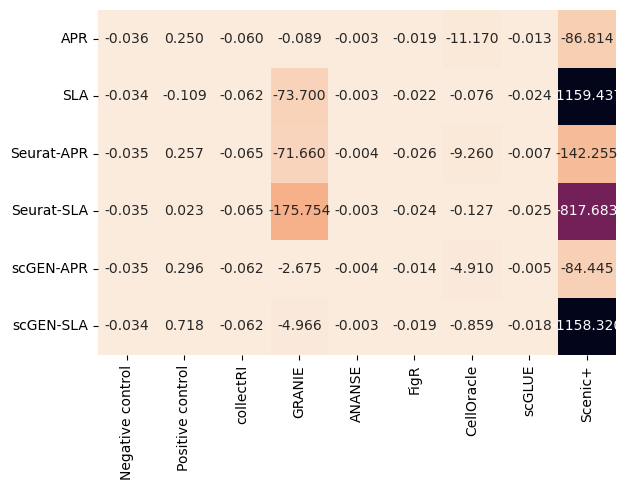

In [30]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1)
xticklabels = ['Negative control', 'Positive control', 'collectRI', 'GRANIE', 'ANANSE', 'FigR', 'CellOracle', 'scGLUE', 'Scenic+']
yticklabels = ['APR', 'SLA', 'Seurat-APR', 'Seurat-SLA', 'scGEN-APR', 'scGEN-SLA']
seaborn.heatmap(mat, ax=ax, square=True, cbar=False, xticklabels=xticklabels, yticklabels=yticklabels, annot=True, fmt='.3f')
plt.tight_layout()
plt.savefig('../output/benchmark/figs/first-validation-heatmap.png', dpi=300, transparent=True)

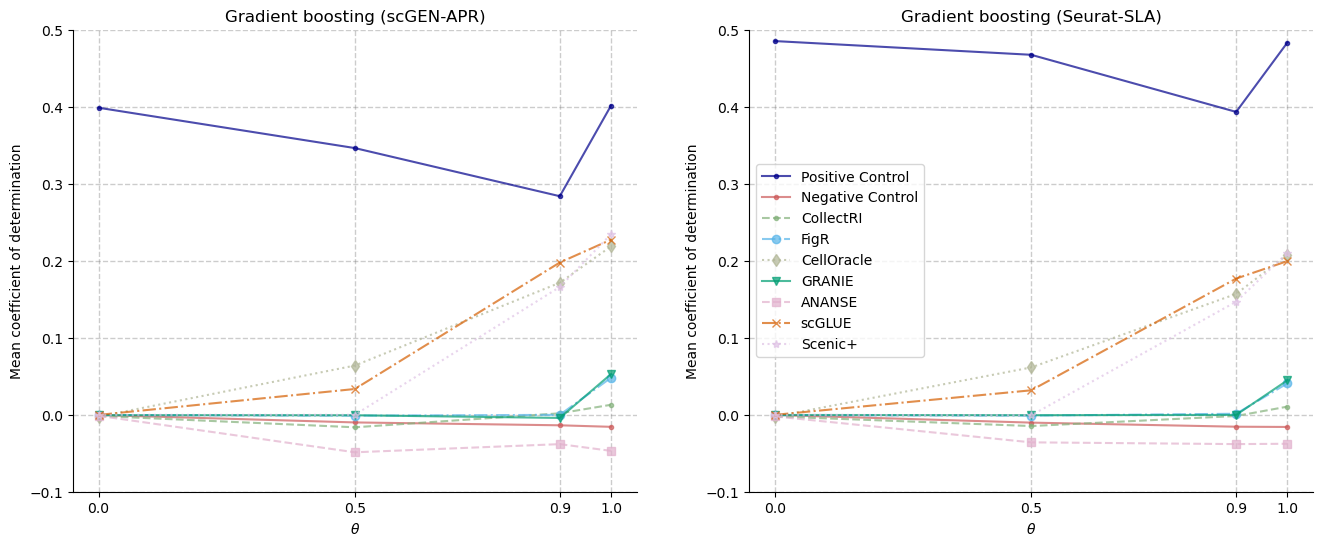

In [37]:
surrogate_names = {
    'CollectRI': 'CollectRI', 'collectRI':'CollectRI', 'collectRI_sign':'CollectRI-signs',
    'Scenic+': 'Scenic+', 'scenicplus':'Scenic+', 'scenicplus_sign': 'Scenic+-signs',
    'CellOracle': 'CellOracle', 'celloracle':'CellOracle', 'celloracle_sign':'CellOracle-signs',
    'FigR': 'FigR', 'figr':'FigR', 'figr_sign':'FigR-signs',
    'baseline':'Baseline',
    'cov_net': 'Pearson cov',
    'GRANIE': 'GRANIE', 'granie':'GRANIE',
    'ANANSE': 'ANANSE', 'ananse':'ANANSE',
    'scGLUE': 'scGLUE', 'scglue':'scGLUE',
    'HKG': 'HKG', 'HKGs':'HKG',
    'positive-control': 'Positive Control', 'positive_control': 'Positive Control',
    'negative-control': 'Negative Control', 'negative_control':'Negative Control',
    'pearson':'Pearson',
    'SL':'SLA'
}

COLORS = {
    'Random': '#74ab8c',
    'CollectRI': '#83b17b',
    'FigR': '#56B4E9',
    'CellOracle': '#b0b595',
    'GRANIE': '#009E73',
    'ANANSE': '#e2b1cd',
    'scGLUE': '#D55E00',
    'Scenic+': '#dfc2e5',
    'HKGs': 'darkblue',
    'Positive': 'darkblue',
    'Negative': 'indianred',
    'Positive Control': 'darkblue',
    'Negative Control': 'indianred'
}

LINESTYLES = {
    'Random': '-',
    'CollectRI': '--',
    'FigR': '-.',
    'CellOracle': ':',
    'GRANIE': '-',
    'ANANSE': '--',
    'scGLUE': '-.',
    'Scenic+': ':',
    'Positive Control': '-',
    'Negative Control': '-'
}

MARKERS = {
    'Random': '.',
    'CollectRI': '.',
    'FigR': 'o',
    'CellOracle': 'd',
    'GRANIE': 'v',
    'ANANSE': 's',
    'scGLUE': 'x',
    'Scenic+': '*',
    'Positive Control': '.',
    'Negative Control': '.'
}

SORTED_METHODS = ['positive_control', 'negative_control', 'collectRI', 'FigR', 'CellOracle', 'GRANIE', 'ANANSE', 'scGLUE', 'scenicplus']

plt.figure(figsize=(16, 6))

for k, (norm2_t, estimator_t) in enumerate(zip(['scgen_pearson', 'seurat_pearson'], ['GB', 'GB'])):
    ax = plt.subplot(1, 2, k + 1)
    ax.grid(alpha=0.4, linewidth=1, color='grey', linestyle='--')
    xs = [0.0, 0.5, 0.9, 1.0]

    for method in SORTED_METHODS:

        series = []

        for theta in xs:
            file = f'{work_dir}/benchmark/scores/{estimator_t}/{theta}/{norm2_t}/{method}_None.json'
            if not os.path.exists(file):
                print(f'Missing file: {file}')
                mean_score = np.nan
            else:
                with open(file, 'r') as f:
                    data = json.load(f)
                mean_score = np.mean(data['mean_score_r2'])

            series.append(float(mean_score))
        
        ax.plot(
            xs, series, label=surrogate_names[method], color=COLORS[surrogate_names[method]],
            linestyle=LINESTYLES[surrogate_names[method]], marker=MARKERS[surrogate_names[method]], alpha=0.7
        )

    ax.set_xticks(xs)
    ax.set_ylim([-0.1, 0.5])

    if k == 0:
        ax.set_title('Gradient boosting (scGEN-APR)')
    elif k == 1:
        ax.set_title('Gradient boosting (Seurat-SLA)')
        ax.legend()
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel('Mean coefficient of determination')
    #ax.set_ylim([0, 0.65])
plt.savefig('../output/benchmark/figs/first-validation-performance-theta.png', dpi=300, transparent=True)
plt.show()